In [ ]:
import cv2
import zipfile
import copy
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import torch.optim as optim
import shutil
import pickle
import torch.nn.functional as F
import shutil
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from google.colab.patches import cv2_imshow
from torchvision.transforms.transforms import ToPILImage
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shutil.rmtree("/content/drive/MyDrive/minset/train")

In [ ]:
#shutil.rmtree("/content/drive/MyDrive/minset")

os.mkdir("/content/")
#os.mkdir("/content/drive/MyDrive/minset/train")
#os.mkdir("/content/drive/MyDrive/minset/test")

FileExistsError: ignored

In [ ]:
##!unzip "/content/drive/MyDrive/CelebA.zip"
!unzip -q "/content/drive/MyDrive/Assign2Dataset/train.zip" -d "content/"

In [ ]:
!unzip -q "/content/drive/MyDrive/Assign2Dataset/test.zip" -d "/content/"

In [ ]:
!du -s /content/drive/MyDrive/Assign2Dataset/Data/test/test_new

348	/content/drive/MyDrive/Assign2Dataset/Data/test/test_new


In [ ]:
!du -s /content/drive/MyDrive/minset/train/train_new

21739	/content/drive/MyDrive/minset/train/train_new


In [ ]:
def train_val_loss_graph(epochs,train_loss_list,val_loss_list):
  epochs_list = range(1,11)
  plt.plot(epochs_list, train_loss_list, 'g', label='Training loss')
  plt.plot(epochs_list, val_loss_list, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
from typing import NewType
def save_model(best_model):
  torch.save({
          "model_state_dict":best_model
      },"/content/drive/MyDrive/minset/model_1.pt")
  


In [ ]:
from tqdm import tqdm
import numpy as np
def train_model(epochs,train_set,val_set,model,optimizer,loss_function):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("device",device)
  train_loss_list=[]
  val_loss_list=[]
  train_acc_list=[]
  val_acc_list=[]
  best_acc = 0
  current_epoch=1
  while current_epoch <= epochs:
    print(current_epoch)
    current_epoch +=1
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for inputs,labels in tqdm(train_set):
      labels = torch.tensor(labels)
      #print(type(labels),"labe;ls")
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      #print("here")
      #print("inputs",inputs)
      #print("here_0")
      outputs = model(inputs)
      #print("here_1")
      loss = loss_function(outputs, labels)
      _, preds = torch.max(outputs, 1)
      
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    #print("test2",running_corrects.double)
    #print(len(train_set.dataset))  
    epoch_loss = running_loss / len(train_set.dataset)
    epoch_acc = running_corrects.double() / len(train_set.dataset)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    print('epoch train Loss: {:.3f} Acc: {:.3f}'.format( epoch_loss, epoch_acc))

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs,labels in tqdm(val_set):
      #print(type(inputs)," >>>type")
      #labels = torch.tensor(labels)
      #print(type(labels)," >>>type")
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      #print("here")
      loss = loss_function(outputs, labels)
      _, preds = torch.max(outputs, 1)
      running_loss += loss.item()*inputs.size(0)
      x = preds.cpu().detach().numpy()
      y = labels.cpu().detach().numpy()
      #print("x >>>>>>>",x,"y >>>>>", y)
      #print("summm ",np.sum(x == y))
      running_corrects += torch.sum(preds == labels)
      #print("test",running_corrects.double)
    epoch_loss = running_loss / len(val_set.dataset)
    epoch_acc = running_corrects.double() / len(val_set.dataset)
    print('epoch val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    val_loss_list.append(epoch_loss)
    val_acc_list.append(epoch_acc)
    if best_acc < epoch_acc or current_epoch == epochs:
      best_acc = epoch_acc
      best_model = copy.deepcopy(model.state_dict())
      save_model(best_model)
  return model,train_loss_list,train_acc_list,val_loss_list,val_acc_list,best_model

In [ ]:
def test(model,test_data,loss_function):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  running_loss = 0
  running_corrects=0
  label = []
  output = []
  for inputs,labels in test_data:
   inputs = inputs.to(device)
   labels = labels.to(device)
   model = model.to(device)
   outputs = model(inputs)
   label.append(labels)
   #output.append(outputs)
   _, preds = torch.max(outputs, 1)
   output.append(preds)
   loss = loss_function(outputs, labels)
   running_loss += loss.item() * inputs.size(0)
   running_corrects += torch.sum(preds == labels.data)
  loss = running_loss/len(test_data.dataset)
  accuracy = running_corrects.double() / len(test_data.dataset)
  return_list =[output, label,loss,accuracy]
  return return_list

In [ ]:
def plot_confusion_matrix(real_labels, predictions):
    df_cm = confusion_matrix(real_labels,predictions, labels=list(range(10)))
    (sn.heatmap(df_cm, annot=True))

In [ ]:
def list_of_tensor_to_array(tensor_list):
  my_list = []
  for i in tensor_list:
    for j in i.cpu().detach():
      my_list.append(j.numpy())
  return my_list    

In [ ]:


transform=transforms.Compose([transforms.ToPILImage(),
                              transforms.ToTensor(),
                              ])
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=transform, target_transform=None):
        df  = pd.read_csv(annotations_file)
        self.img_labels = df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]))
        image = read_image(img_path)
        #print("type >>>  ", image)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label




 
train_set_1 = CustomImageDataset("/content/drive/MyDrive/minset/updated_csv.csv","/content/content/train_new")
train_loader_1 = torch.utils.data.DataLoader(train_set_1, batch_size=100, shuffle = True)
            
print(len(train_set_1))


test_set_1 = CustomImageDataset("/content/drive/MyDrive/minset/test.csv","/content/test_new")
test_loader = torch.utils.data.DataLoader(test_set_1, batch_size=100,
                                          shuffle=True)

val_set = CustomImageDataset("/content/drive/MyDrive/minset/val.csv","/content/test_new")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100,
                                          shuffle=True)

'''
test_idx, val_idx =train_test_split([i for i in range(len(test_set_1))], test_size=.50)
test_set = Subset(test_set_1, test_idx)
val_set= Subset(test_set_1 ,val_idx)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                          shuffle=True,pin_memory=True,num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=100,
                                          shuffle=True,pin_memory=True,num_workers=2)
'''


43470


'\ntest_idx, val_idx =train_test_split([i for i in range(len(test_set_1))], test_size=.50)\ntest_set = Subset(test_set_1, test_idx)\nval_set= Subset(test_set_1 ,val_idx)\n\ntest_loader = torch.utils.data.DataLoader(test_set, batch_size=100,\n                                          shuffle=True,pin_memory=True,num_workers=2)\n\nval_loader = torch.utils.data.DataLoader(val_set, batch_size=100,\n                                          shuffle=True,pin_memory=True,num_workers=2)\n'

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            conv_bn(3,  32, 2), 
            conv_dw(32,  64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(128 , 10)

    def forward(self, x):
        x = self.model(x.float())
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
model = Net()  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)     
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01,momentum =0.9)
epochs = 10
model = model
train_set = train_loader_1
val_set = val_loader
model, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_model = train_model(epochs,train_set,val_set,model,optimizer,loss_function)   

Net(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

100%|██████████| 435/435 [00:20<00:00, 21.13it/s]


epoch train Loss: 0.729 Acc: 0.794


100%|██████████| 50/50 [00:01<00:00, 25.74it/s]


epoch val Loss: 0.7524 Acc: 0.7012
2


100%|██████████| 435/435 [00:18<00:00, 23.46it/s]


epoch train Loss: 0.169 Acc: 0.953


100%|██████████| 50/50 [00:01<00:00, 26.31it/s]


epoch val Loss: 0.4123 Acc: 0.8580
3


100%|██████████| 435/435 [00:18<00:00, 23.43it/s]


epoch train Loss: 0.105 Acc: 0.972


100%|██████████| 50/50 [00:01<00:00, 26.39it/s]


epoch val Loss: 0.2522 Acc: 0.9241
4


100%|██████████| 435/435 [00:18<00:00, 23.55it/s]


epoch train Loss: 0.076 Acc: 0.979


100%|██████████| 50/50 [00:01<00:00, 26.15it/s]


epoch val Loss: 0.1948 Acc: 0.9395
5


100%|██████████| 435/435 [00:18<00:00, 23.39it/s]


epoch train Loss: 0.060 Acc: 0.983


100%|██████████| 50/50 [00:01<00:00, 26.50it/s]


epoch val Loss: 0.1684 Acc: 0.9499
6


100%|██████████| 435/435 [00:18<00:00, 23.34it/s]


epoch train Loss: 0.051 Acc: 0.986


100%|██████████| 50/50 [00:01<00:00, 26.64it/s]


epoch val Loss: 0.1121 Acc: 0.9690
7


100%|██████████| 435/435 [00:18<00:00, 23.52it/s]


epoch train Loss: 0.044 Acc: 0.988


100%|██████████| 50/50 [00:01<00:00, 26.60it/s]


epoch val Loss: 0.1250 Acc: 0.9625
8


100%|██████████| 435/435 [00:18<00:00, 23.74it/s]


epoch train Loss: 0.037 Acc: 0.989


100%|██████████| 50/50 [00:01<00:00, 27.93it/s]


epoch val Loss: 0.1292 Acc: 0.9617
9


100%|██████████| 435/435 [00:18<00:00, 23.23it/s]


epoch train Loss: 0.033 Acc: 0.991


100%|██████████| 50/50 [00:01<00:00, 26.24it/s]


epoch val Loss: 0.1425 Acc: 0.9554
10


100%|██████████| 435/435 [00:18<00:00, 23.22it/s]


epoch train Loss: 0.029 Acc: 0.992


100%|██████████| 50/50 [00:01<00:00, 25.70it/s]

epoch val Loss: 0.0971 Acc: 0.9692


In [ ]:
model.parameters()

<generator object Module.parameters at 0x7f7eb50c1e50>

In [ ]:
## Training and Validation Loss 

In [ ]:
## Training and Validation Loss 
train_val_loss_graph(epochs,train_loss_list,val_loss_list)

NameError: ignored

In [ ]:
y_pred, y_true, loss, accuracy = test(model, test_loader, loss_function)
print("Test Loss >>",loss,"\nTest Accuracy >>> ", accuracy)

Test Loss >> 0.10711465563365774 
Test Accuracy >>>  tensor(0.9684, device='cuda:0', dtype=torch.float64)


In [ ]:
predictions  = list_of_tensor_to_array(y_pred)
real_labels =   list_of_tensor_to_array(y_true)

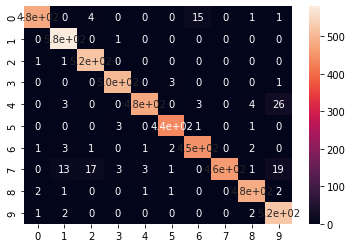

In [ ]:
plot_confusion_matrix(real_labels, predictions)

In [ ]:
#https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool1d.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = nn.Sequential(   # (1,28,28)
            nn.Conv2d(1, 28, 5),
            nn.Conv2d(28, 32, 3),
            nn.Conv2d(32, 64, 3),
            nn.Conv2d(64, 128, 3),
            
        )
        self.gap = nn.MaxPool1d(kernel_size=10)#https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/3
        self.fc = nn.Linear(4147, 10)

    def forward(self, x):
        x = self.model(x.float())
        x = x.view(x.size(0), -1)
        x = self.gap(x)
        x = self.fc(x)
        return x
model = Net()    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)        
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
epochs = 10
model = model
train_set = train_loader_1
val_set = val_loader
model, train_loss_list, train_acc_list, val_loss_list, val_acc_list, best_model = train_model(epochs,train_set,val_set,model,optimizer,loss_function)

Net(
  (model): Sequential(
    (0): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(28, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (gap): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4147, out_features=10, bias=True)
)
device cuda:0
1


100%|██████████| 435/435 [00:20<00:00, 21.31it/s]


epoch train Loss: 0.761 Acc: 0.793


100%|██████████| 50/50 [00:01<00:00, 27.04it/s]


epoch val Loss: 0.3779 Acc: 0.8736
2


100%|██████████| 435/435 [00:20<00:00, 21.41it/s]


epoch train Loss: 0.165 Acc: 0.950


100%|██████████| 50/50 [00:01<00:00, 27.18it/s]


epoch val Loss: 0.2929 Acc: 0.9065
3


100%|██████████| 435/435 [00:20<00:00, 21.53it/s]


epoch train Loss: 0.119 Acc: 0.963


100%|██████████| 50/50 [00:01<00:00, 27.53it/s]


epoch val Loss: 0.1268 Acc: 0.9604
4


100%|██████████| 435/435 [00:20<00:00, 21.36it/s]


epoch train Loss: 0.094 Acc: 0.971


100%|██████████| 50/50 [00:01<00:00, 26.78it/s]


epoch val Loss: 0.1326 Acc: 0.9596
5


100%|██████████| 435/435 [00:20<00:00, 20.85it/s]


epoch train Loss: 0.081 Acc: 0.975


100%|██████████| 50/50 [00:01<00:00, 26.84it/s]


epoch val Loss: 0.1432 Acc: 0.9544
6


100%|██████████| 435/435 [00:20<00:00, 21.54it/s]


epoch train Loss: 0.072 Acc: 0.978


100%|██████████| 50/50 [00:01<00:00, 26.71it/s]


epoch val Loss: 0.1362 Acc: 0.9533
7


100%|██████████| 435/435 [00:20<00:00, 21.28it/s]


epoch train Loss: 0.064 Acc: 0.980


100%|██████████| 50/50 [00:01<00:00, 27.27it/s]


epoch val Loss: 0.1372 Acc: 0.9535
8


100%|██████████| 435/435 [00:20<00:00, 21.55it/s]


epoch train Loss: 0.060 Acc: 0.981


100%|██████████| 50/50 [00:01<00:00, 26.58it/s]


epoch val Loss: 0.0938 Acc: 0.9677
9


100%|██████████| 435/435 [00:20<00:00, 21.38it/s]


epoch train Loss: 0.054 Acc: 0.983


100%|██████████| 50/50 [00:01<00:00, 26.94it/s]


epoch val Loss: 0.0867 Acc: 0.9710
10


100%|██████████| 435/435 [00:20<00:00, 21.50it/s]


epoch train Loss: 0.053 Acc: 0.983


100%|██████████| 50/50 [00:01<00:00, 27.04it/s]

epoch val Loss: 0.0809 Acc: 0.9728


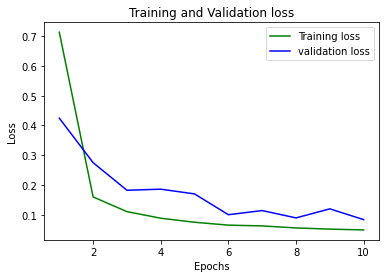

In [ ]:
## Training and Validation Loss 
train_val_loss_graph(epochs,train_loss_list,val_loss_list)

In [ ]:
y_pred, y_true, loss, accuracy = test(model,test_loader,loss_function)
print("Test Loss >>",loss,"\nTest Accuracy >>> ", accuracy)

Test Loss >> 0.09450269008051289 
Test Accuracy >>>  tensor(0.9708, device='cuda:0', dtype=torch.float64)


In [ ]:
predictions  = list_of_tensor_to_array(y_pred)
real_labels =   list_of_tensor_to_array(y_true)

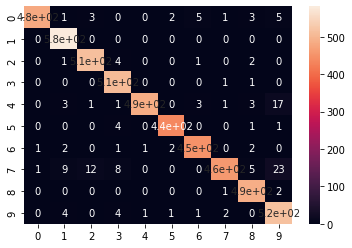

In [ ]:
plot_confusion_matrix(real_labels,predictions)

In [ ]:
model.con.weight.data

AttributeError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
df_cm = confusion_matrix(y_true[0].cpu().detach(), y_pred.cpu().detach(), labels=list(range(10)))
sn.heatmap(df_cm, annot=True)

AttributeError: ignored

In [ ]:
print(c.shape)
print(a.shape)

(5071,)
(5071,)


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = c
confusion_matrix(y_true, y_pred, labels=list(range(10)))


In [ ]:
path  ="/content/content/train_new"
l = os.listdir(path)

In [ ]:
len(l)

43470

In [ ]:
l

['33333.png',
 '54096.png',
 '51041.png',
 '48084.png',
 '12984.png',
 '33270.png',
 '2060.png',
 '14454.png',
 '30585.png',
 '881.png',
 '19256.png',
 '4140.png',
 '2725.png',
 '40950.png',
 '15270.png',
 '45217.png',
 '8986.png',
 '58671.png',
 '9842.png',
 '35277.png',
 '10162.png',
 '3202.png',
 '12487.png',
 '29929.png',
 '57802.png',
 '56538.png',
 '48546.png',
 '23739.png',
 '4394.png',
 '32548.png',
 '32436.png',
 '20807.png',
 '4129.png',
 '31241.png',
 '9484.png',
 '55980.png',
 '33612.png',
 '15444.png',
 '56617.png',
 '24917.png',
 '3494.png',
 '15906.png',
 '37573.png',
 '26543.png',
 '56960.png',
 '19869.png',
 '12086.png',
 '16822.png',
 '47677.png',
 '15749.png',
 '26037.png',
 '8626.png',
 '45666.png',
 '4490.png',
 '51220.png',
 '49397.png',
 '26599.png',
 '18903.png',
 '43433.png',
 '25914.png',
 '40536.png',
 '49589.png',
 '51360.png',
 '53845.png',
 '58730.png',
 '39539.png',
 '34108.png',
 '8040.png',
 '36752.png',
 '13343.png',
 '56145.png',
 '17885.png',
 '37117

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Assign2Dataset/Data/train/train.csv")
df = df[pd.DataFrame(df.FileName.tolist()).isin(l).any(1).values]
df.to_csv("/content/drive/MyDrive/minset/updated_csv.csv",index= False)

In [ ]:
df.shape

(40620, 2)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Assign2Dataset/Data/train/train.csv")
df

,FileName,Label
0,23258.png,9
1,39200.png,9
2,29013.png,9
3,20751.png,9
4,10686.png,9
...,...,...
43465,31645.png,5
43466,33734.png,5
43467,22639.png,5
43468,21330.png,5


In [ ]:
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/minset/test/test.csv")
df = df.sample(frac=1)

msk = np.random.rand(len(df)) < 0.5

test = df[msk]

val = df[~msk]

In [ ]:
val.head()

,FileName,Label
2666,4468.png,7
721,3339.png,9
2827,5671.png,7
2041,9691.png,7
1883,1765.png,0


In [ ]:
test.to_csv("/content/drive/MyDrive/minset/test.csv",index=False)
val.to_csv("/content/drive/MyDrive/minset/val.csv",index=False)

In [ ]:
path  ="/content/drive/MyDrive/minset/test/test_new"
l = os.listdir(path)

In [ ]:
len(l)

10000

In [ ]:
l

['916.png',
 '7599.png',
 '4846.png',
 '2265.png',
 '7305.png',
 '3157.png',
 '8730.png',
 '781.png',
 '9728.png',
 '6954.png',
 '7056.png',
 '1697.png',
 '5849.png',
 '8832.png',
 '539.png',
 '8149.png',
 '7733.png',
 '6028.png',
 '2997.png',
 '792.png',
 '5955.png',
 '6438.png',
 '9282.png',
 '4096.png',
 '2190.png',
 '6427.png',
 '9929.png',
 '151.png',
 '7482.png',
 '1526.png',
 '9345.png',
 '9658.png',
 '4407.png',
 '9538.png',
 '9201.png',
 '5294.png',
 '1086.png',
 '7158.png',
 '9862.png',
 '4441.png',
 '7639.png',
 '1396.png',
 '8122.png',
 '8706.png',
 '9079.png',
 '9093.png',
 '8860.png',
 '4140.png',
 '6876.png',
 '4622.png',
 '2719.png',
 '9978.png',
 '1348.png',
 '1621.png',
 '4614.png',
 '858.png',
 '1471.png',
 '3353.png',
 '2321.png',
 '8145.png',
 '9053.png',
 '4.png',
 '4849.png',
 '3524.png',
 '3288.png',
 '5611.png',
 '3858.png',
 '4552.png',
 '63.png',
 '6691.png',
 '531.png',
 '9071.png',
 '4824.png',
 '8523.png',
 '3404.png',
 '5219.png',
 '2482.png',
 '2577.png'

In [ ]:
test_list_set = set(l)
if '7194.png' in test_list_set :
    print ("Element Exists")

Element Exists


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/minset/test/test.csv")
df = df[pd.DataFrame(df.FileName.tolist()).isin(l).any(1).values]
df.to_csv("/content/drive/MyDrive/minset/my_csv.csv",index= False)

In [ ]:
df.shape

(10000, 2)

In [ ]:
PATH = "/content/drive/MyDrive/minset/model2.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

RuntimeError: ignored